<a href="https://colab.research.google.com/github/drSigPro/CNN-Classifier-Analysis/blob/main/transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine-Grained Image Classification of Bird Species using Transfer Learning with ResNet50

This code implements a deep learning model for fine-grained image classification of bird species using transfer learning with a pre-trained ResNet50 model (and by now you should guess why ResNet50!). It leverages the CUB_200_2011 dataset, which contains images of 200 bird species. The code includes data loading, preprocessing, model training, evaluation, and visualization of results, including confusion matrices and t-SNE plots. It also incorporates techniques like Grad-CAM for visualizing class activation maps and saliency maps for understanding model predictions.

**Key features:**

- Utilizes transfer learning with ResNet50 for efficient training.
- Employs data augmentation for improved model generalization.
- Implements one-cycle learning rate scheduler for faster convergence.
- Calculates top-k accuracy for evaluating model performance.
- Visualizes confusion matrices and misclassified examples for analysis.
- Generates t-SNE plots for visualizing feature representations.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

The below code snippet is all about ensuring reproducibility in your machine learning experiments. In simpler terms, it ensures that if you run this code multiple times, you should get the same results each time. This is crucial for debugging and comparing different approaches.

In [ ]:
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

The below two lines of code allow your Colab notebook to access files stored in your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# We will be using the birds dataset with 200 classes of birds from Caltech: https://www.vision.caltech.edu/datasets/cub_200_2011/

**Warning: Images in this dataset overlap with images in ImageNet. **

Make sure you download the dataset (zip file which already split into train-test dataset) from [link](https://drive.google.com/file/d/1pt1BcNDcJsEp7QLJgPqGLkuVXy5GeUPw/view?usp=sharing) and upload to a folder in your drive. Once you upload, update the path to the zip file in the below code at "zip_path"

In [ ]:
# Path to your compressed file in Google Drive
zip_path = '/content/drive/MyDrive/AAI3001/Datasets/CUB_200_2011_Split.zip' #Make sure the path to your drive folder is updated!
ROOT = '/content'
datasets.utils.extract_archive(zip_path, ROOT)

'/content'

Assign the train and test directories (I have done the split for you to enable reproducibility and to avoid train data getting into test data)

In [ ]:
data_dir = os.path.join(ROOT, 'CUB_200_2011_Split')
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

Typical ImageNet transforms

In [ ]:
pretrained_size = 224 #for ResNet
pretrained_means = [0.485, 0.456, 0.406]
pretrained_stds= [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means,
                                                std = pretrained_stds)
                       ])

In [ ]:
train_data = datasets.ImageFolder(root = train_dir,
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = test_transforms)

Create a Validation dataset within the train dataset (a good practice)

In [ ]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data,
                                           [n_train_examples, n_valid_examples])

In [ ]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [ ]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 8472
Number of validation examples: 942
Number of testing examples: 2374


In [ ]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data,
                                batch_size = BATCH_SIZE)

Get the class labels as only numbers

In [ ]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label

classes = [format_label(c) for c in test_data.classes]

Display some sample images for sanity check

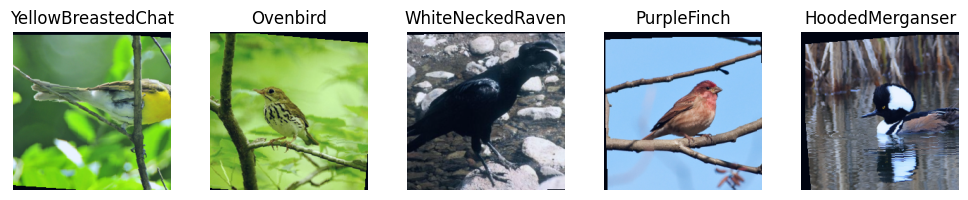

In [ ]:
N = 5

# Get one batch from the test_iterator
data_iter = iter(train_iterator)
images, labels = next(data_iter)  # Fetch one batch using next()

# Randomly select N samples from the batch
random_indices = random.sample(range(BATCH_SIZE), N)
random_images = images[random_indices]
random_labels = labels[random_indices]

# Plot the random images
fig, axes = plt.subplots(1, N, figsize=(N * 2, 2))
for i in range(N):
    img = random_images[i].permute(1, 2, 0)  # Reorder the tensor for plotting (channels last)
    # Normalize the image data to [0, 1]
    img = (img - img.min()) / (img.max() - img.min())
    axes[i].imshow(img.numpy())  # Convert tensor to numpy for display
    axes[i].set_title(f"{classes[random_labels[i].item()]}")
    axes[i].axis('off')  # Hide axes for cleaner visualization

plt.tight_layout()
plt.show()

Load the pretrained ResNet50 model (feel free to try out other models and you know why we chose ResNet! If not, refer to the compare ImageNet model experiments)

In [ ]:
model = models.resnet50(pretrained = True)
print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 176MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

The below code snippet is essentially tailoring the ResNet50 model to work with a new dataset. It does this by:

Finding out how many input features the model's final layer expects.
Determining the desired number of output classes based on the dataset.
Creating a new final layer with the correct input and output dimensions.
Replacing the model's original final layer with the new one.

In [ ]:
IN_FEATURES = model.fc.in_features
OUTPUT_DIM = len(test_data.classes)

fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
model.fc = fc

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 23,917,832 trainable parameters


In [ ]:
#Hyper parameters
EPOCHS = 10
LR = 1e-3

# Setting up optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
MAX_LRS = [p['lr'] for p in optimizer.param_groups]
scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

The below function assesses how often the correct label is within the top k predictions made by the model, providing a measure of its performance. Historically, for the ImageNet challenge the models are evaluated for top 1% and 5% accuracy.

Top-k Accuracy = (Number of Correct Top-k Predictions) / (Total Number of Predictions)

Where:

Number of Correct Top-k Predictions: This is the count of instances where the true label is among the top k predictions made by the model for a given sample.
Total Number of Predictions: This is simply the total number of samples being evaluated.

In [ ]:
def calculate_topk_accuracy(y_pred, y, k = 5):
    with torch.no_grad():
        batch_size = y.shape[0]
        _, top_pred = y_pred.topk(k, 1)
        top_pred = top_pred.t()
        correct = top_pred.eq(y.view(1, -1).expand_as(top_pred))
        correct_1 = correct[:1].reshape(-1).float().sum(0, keepdim = True)
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim = True)
        acc_1 = correct_1 / batch_size
        acc_k = correct_k / batch_size
    return acc_1, acc_k

In [ ]:
def train(model, iterator, optimizer, criterion, scheduler, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)

        acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        scheduler.step()

        epoch_loss += loss.item()
        epoch_acc_1 += acc_1.item()
        epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc_1 = 0
    epoch_acc_5 = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc_1, acc_5 = calculate_topk_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc_1 += acc_1.item()
            epoch_acc_5 += acc_5.item()

    epoch_loss /= len(iterator)
    epoch_acc_1 /= len(iterator)
    epoch_acc_5 /= len(iterator)

    return epoch_loss, epoch_acc_1, epoch_acc_5

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Running the training epochs. Do note we are saving the model to the Gdrive. You need to update the path accordingly if you want to use it in next experiment.

In [ ]:
best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc_1, train_acc_5 = train(model, train_iterator, optimizer, criterion, scheduler, device)
    valid_loss, valid_acc_1, valid_acc_5 = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/AAI3001/Week8/ResNet50_birds_model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc @1: {train_acc_1*100:6.2f}% | ' \
          f'Train Acc @5: {train_acc_5*100:6.2f}%')
    print(f'\tValid Loss: {valid_loss:.3f} | Valid Acc @1: {valid_acc_1*100:6.2f}% | ' \
          f'Valid Acc @5: {valid_acc_5*100:6.2f}%')

Epoch: 01 | Epoch Time: 2m 21s
	Train Loss: 4.253 | Train Acc @1:  19.50% | Train Acc @5:  41.86%
	Valid Loss: 2.593 | Valid Acc @1:  34.49% | Valid Acc @5:  73.14%
Epoch: 02 | Epoch Time: 2m 20s
	Train Loss: 2.269 | Train Acc @1:  41.29% | Train Acc @5:  76.67%
	Valid Loss: 3.448 | Valid Acc @1:  21.26% | Valid Acc @5:  55.67%
Epoch: 03 | Epoch Time: 2m 20s
	Train Loss: 2.244 | Train Acc @1:  39.46% | Train Acc @5:  75.07%
	Valid Loss: 3.219 | Valid Acc @1:  28.83% | Valid Acc @5:  61.73%
Epoch: 04 | Epoch Time: 2m 21s
	Train Loss: 1.714 | Train Acc @1:  52.05% | Train Acc @5:  83.80%
	Valid Loss: 1.912 | Valid Acc @1:  49.44% | Valid Acc @5:  79.99%
Epoch: 05 | Epoch Time: 2m 22s
	Train Loss: 1.275 | Train Acc @1:  62.79% | Train Acc @5:  90.63%
	Valid Loss: 1.609 | Valid Acc @1:  54.52% | Valid Acc @5:  85.73%
Epoch: 06 | Epoch Time: 2m 21s
	Train Loss: 0.924 | Train Acc @1:  72.41% | Train Acc @5:  94.15%
	Valid Loss: 1.284 | Valid Acc @1:  65.26% | Valid Acc @5:  90.63%
Epoch: 07 

We could just continue with the trained model, but just loading the trained weights to ensure they are saved correctly (A similar process is employed in the next experiment on model explainability)

Once the weights are loaded, you can see the performance on the test dataset

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/AAI3001/Week8/ResNet50_birds_model.pt'))

test_loss, test_acc_1, test_acc_5 = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc @1: {test_acc_1*100:6.2f}% | ' \
      f'Test Acc @5: {test_acc_5*100:6.2f}%')

<ipython-input-25-bafced05e28a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/drive/MyDrive/AAI3001/Week8/ResNet50_birds_model.

Test Loss: 0.827 | Test Acc @1:  77.14% | Test Acc @5:  94.16%


# Generate the confusion matrix

In [ ]:
def get_predictions(model, iterator):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator)
pred_labels = torch.argmax(probs, 1)

In [ ]:
def plot_confusion_matrix(labels, pred_labels, classes):

    fig = plt.figure(figsize = (50, 50));
    ax = fig.add_subplot(1, 1, 1);
    cm = confusion_matrix(labels, pred_labels);
    cm = ConfusionMatrixDisplay(cm, display_labels = classes);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)
    fig.delaxes(fig.axes[1]) #delete colorbar
    plt.xticks(rotation = 90)
    plt.xlabel('Predicted Label', fontsize = 50)
    plt.ylabel('True Label', fontsize = 50)

Confusion matrix will be huge 200x200 and not perfectly readable, but what we really want is the diagonal matrix to be the stongest (which is what we observe below)!

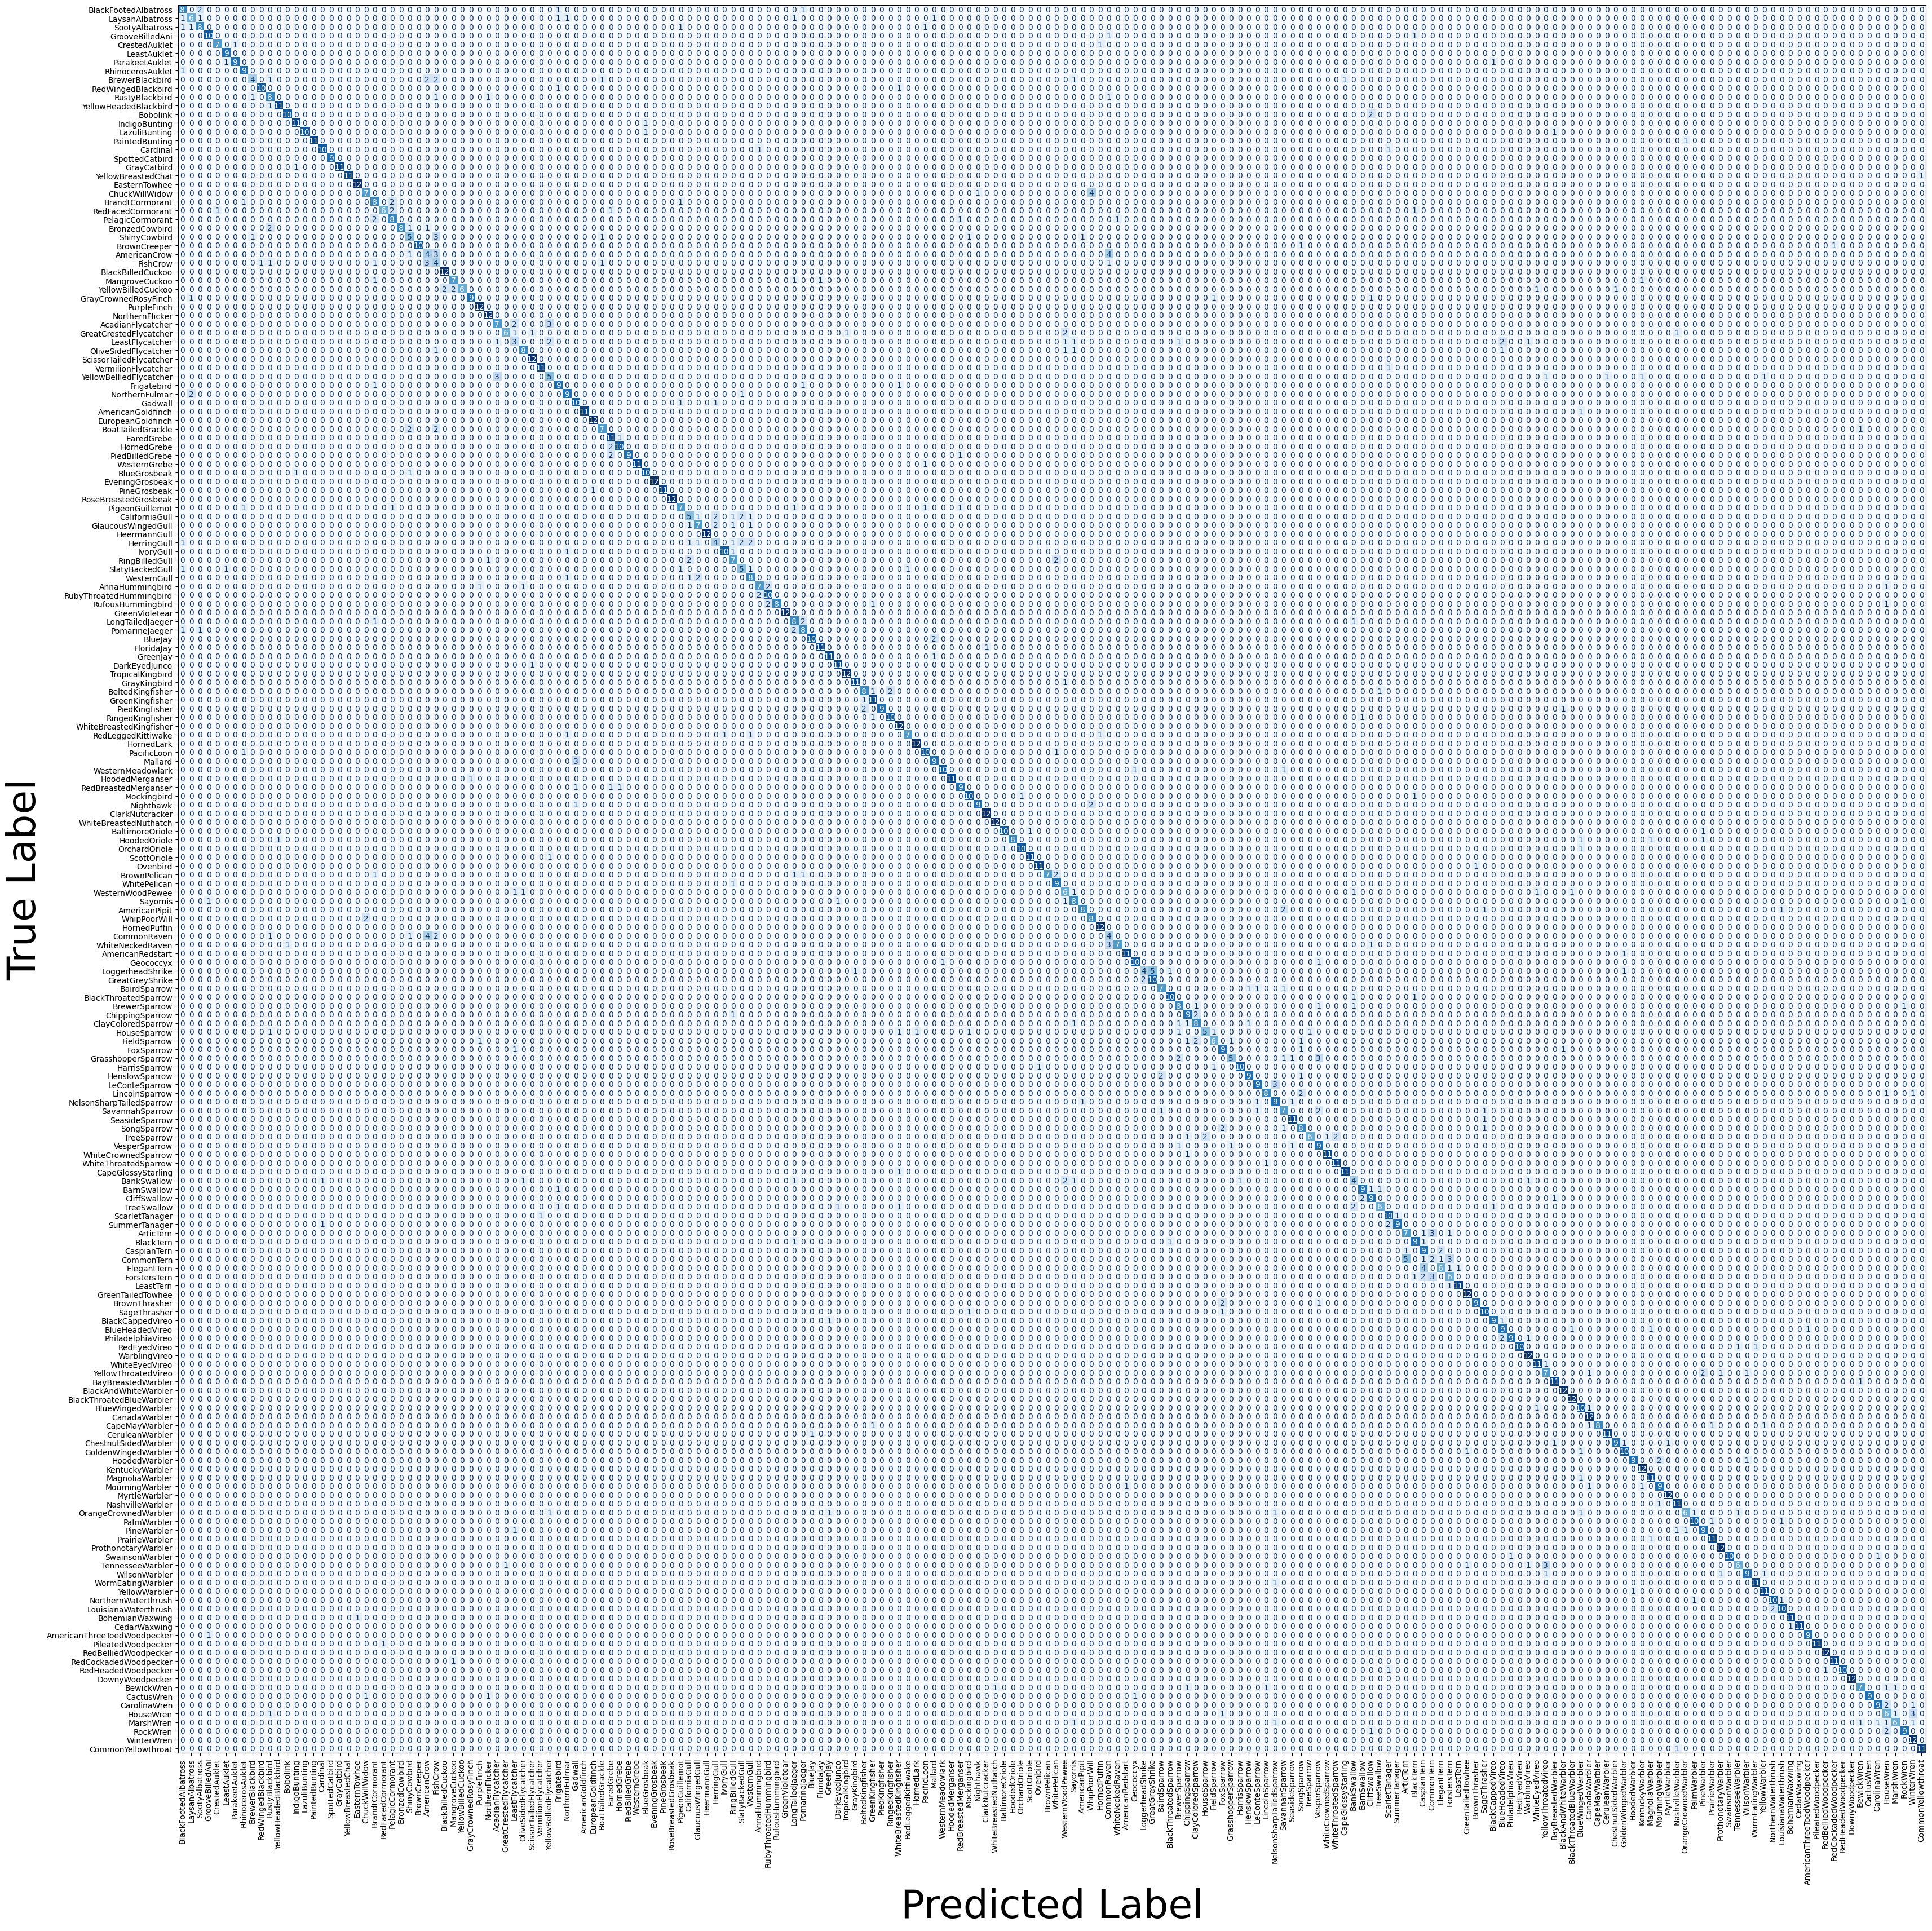

In [ ]:
plot_confusion_matrix(labels, pred_labels, classes)

# Now interesting to see the most wrong examples! It will be good to save the wrong images and use for model explainability why it is failing!

In [ ]:
corrects = torch.eq(labels, pred_labels)
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [ ]:
def plot_most_incorrect(incorrect, classes, n_images, normalize = True):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (25, 20))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)

        image, true_label, probs = incorrect[i]
        image = image.permute(1, 2, 0)
        true_prob = probs[true_label]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
        true_class = classes[true_label]
        incorrect_class = classes[incorrect_label]

        if normalize:
            image = image - image.min()
            image = image / image.max()

        ax.imshow(image.cpu().numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {incorrect_class} ({incorrect_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

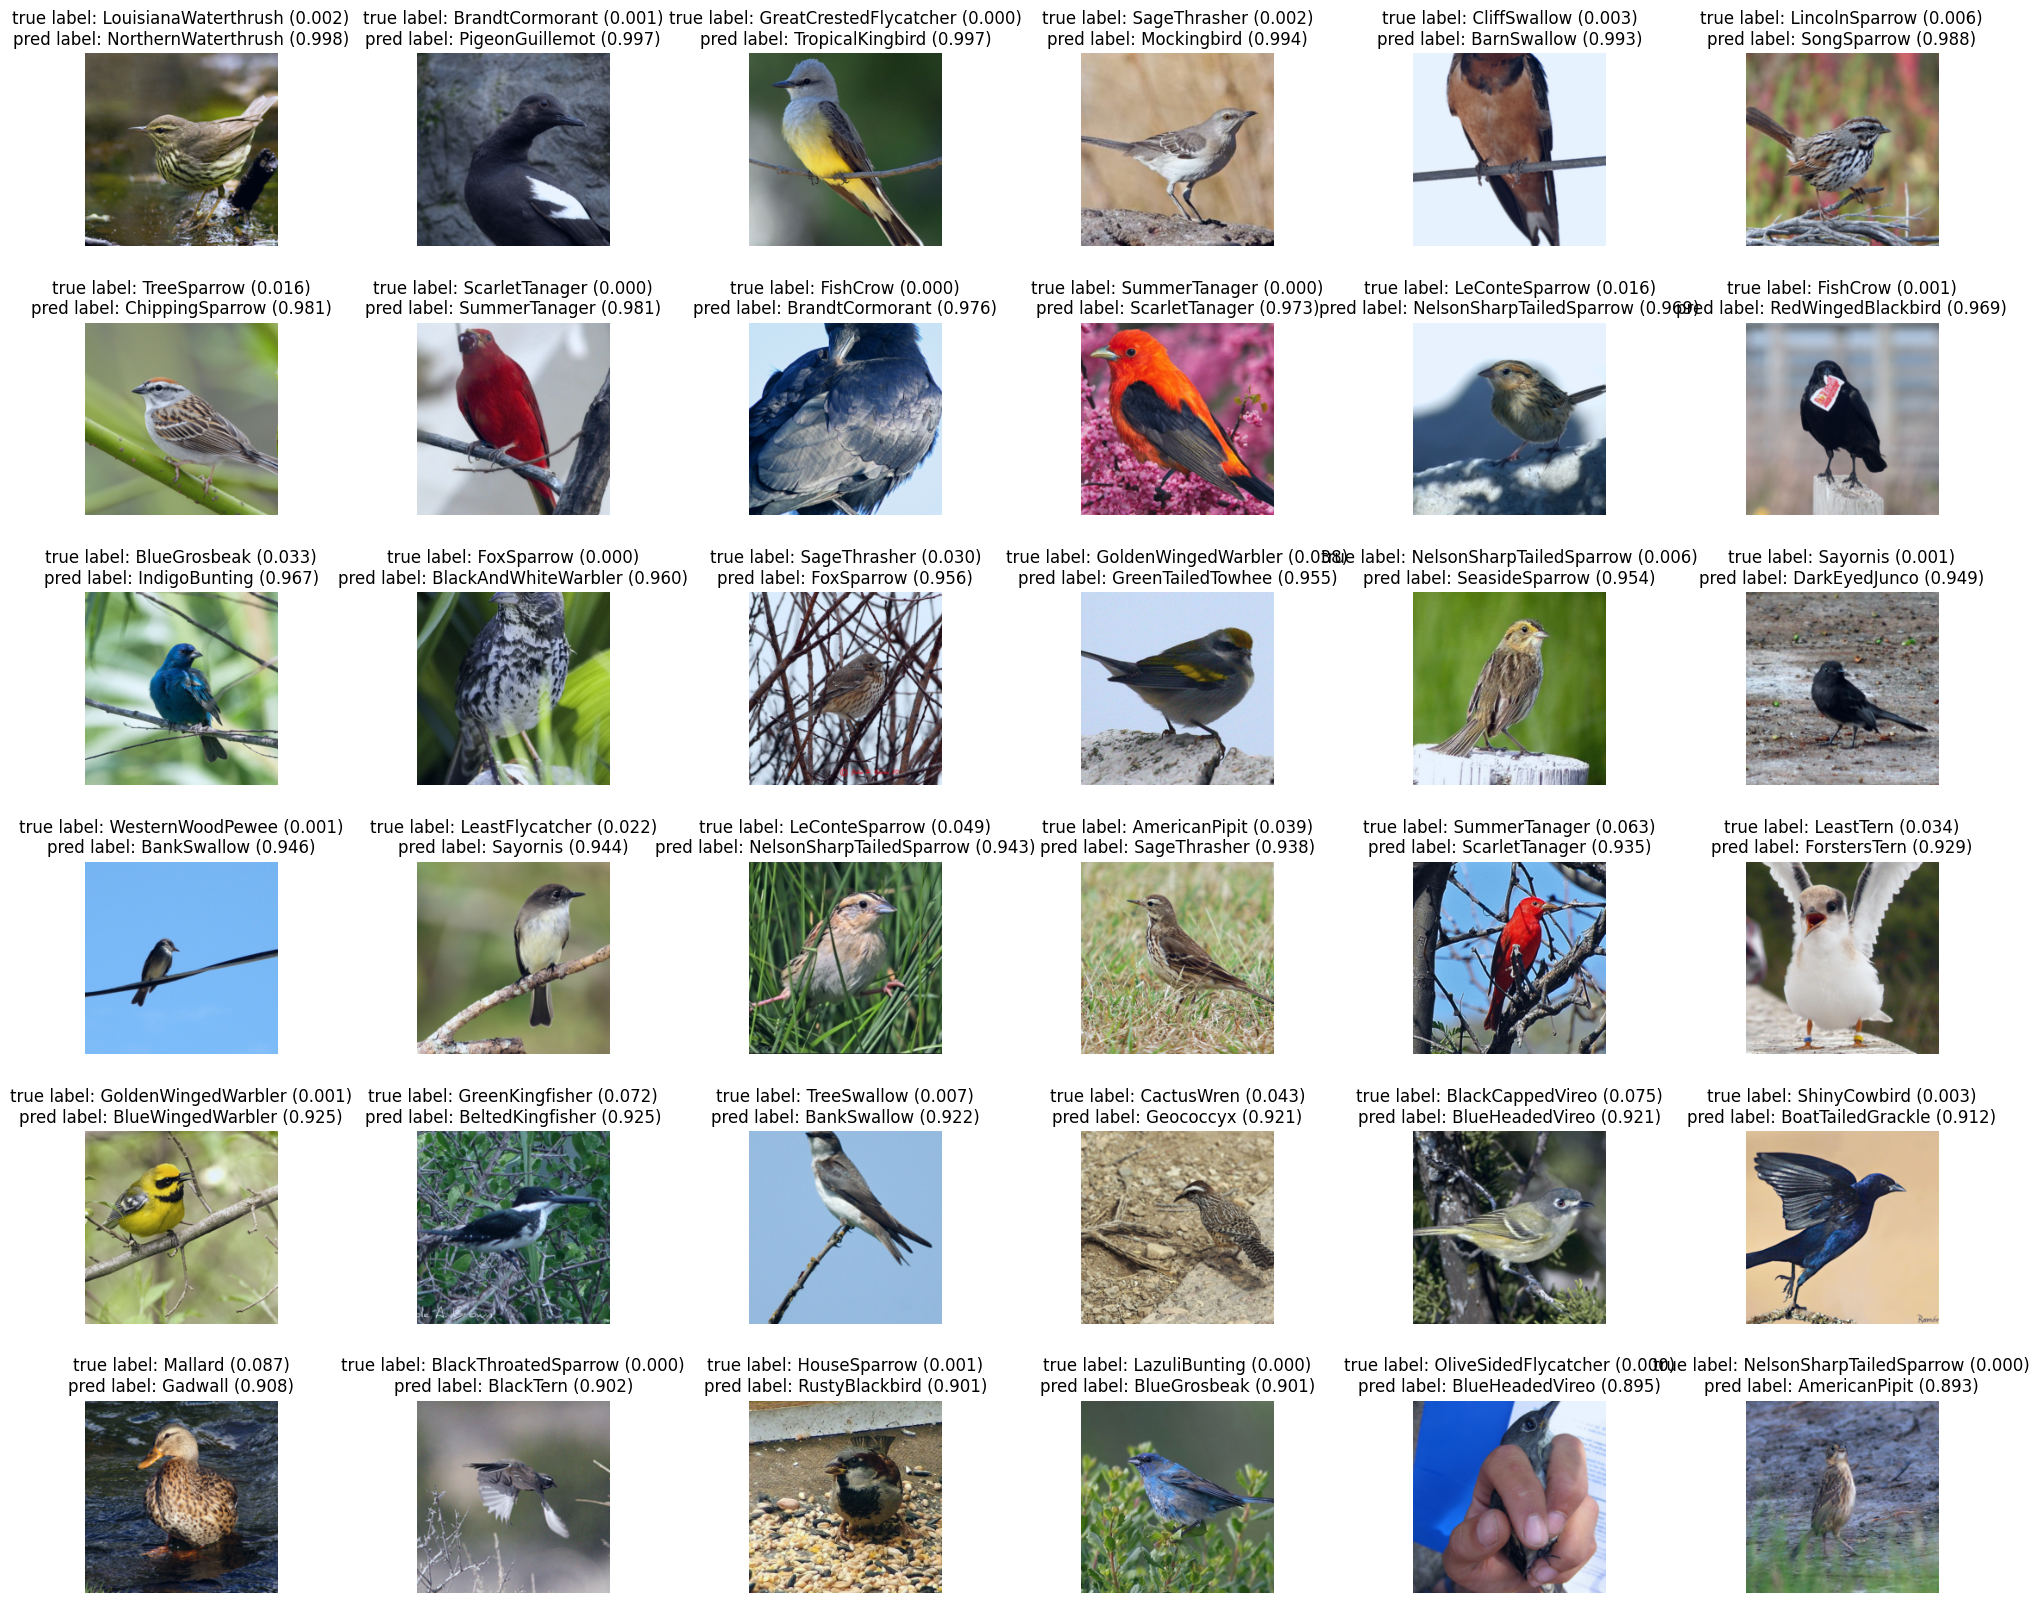

In [ ]:
N_IMAGES = 36

plot_most_incorrect(incorrect_examples, classes, N_IMAGES)

# Now lets see the clustering ability (in a way shows if the model features are able to clearly seperate the classes) using t-SNE

In [ ]:
def get_representations(model, iterator):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred = model(x)

            outputs.append(y_pred.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim = 0)
    labels = torch.cat(labels, dim = 0)

    return outputs, labels

In [ ]:
outputs, labels = get_representations(model, train_iterator)

In [ ]:
def get_tsne(data, n_components = 2, n_images = None):

    if n_images is not None:
        data = data[:n_images]

    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

In [ ]:
def plot_representations(data, labels, classes, n_images = None):

    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]

    fig = plt.figure(figsize = (15, 15))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'hsv')
    #handles, _ = scatter.legend_elements(num = None)
    #legend = plt.legend(handles = handles, labels = classes)

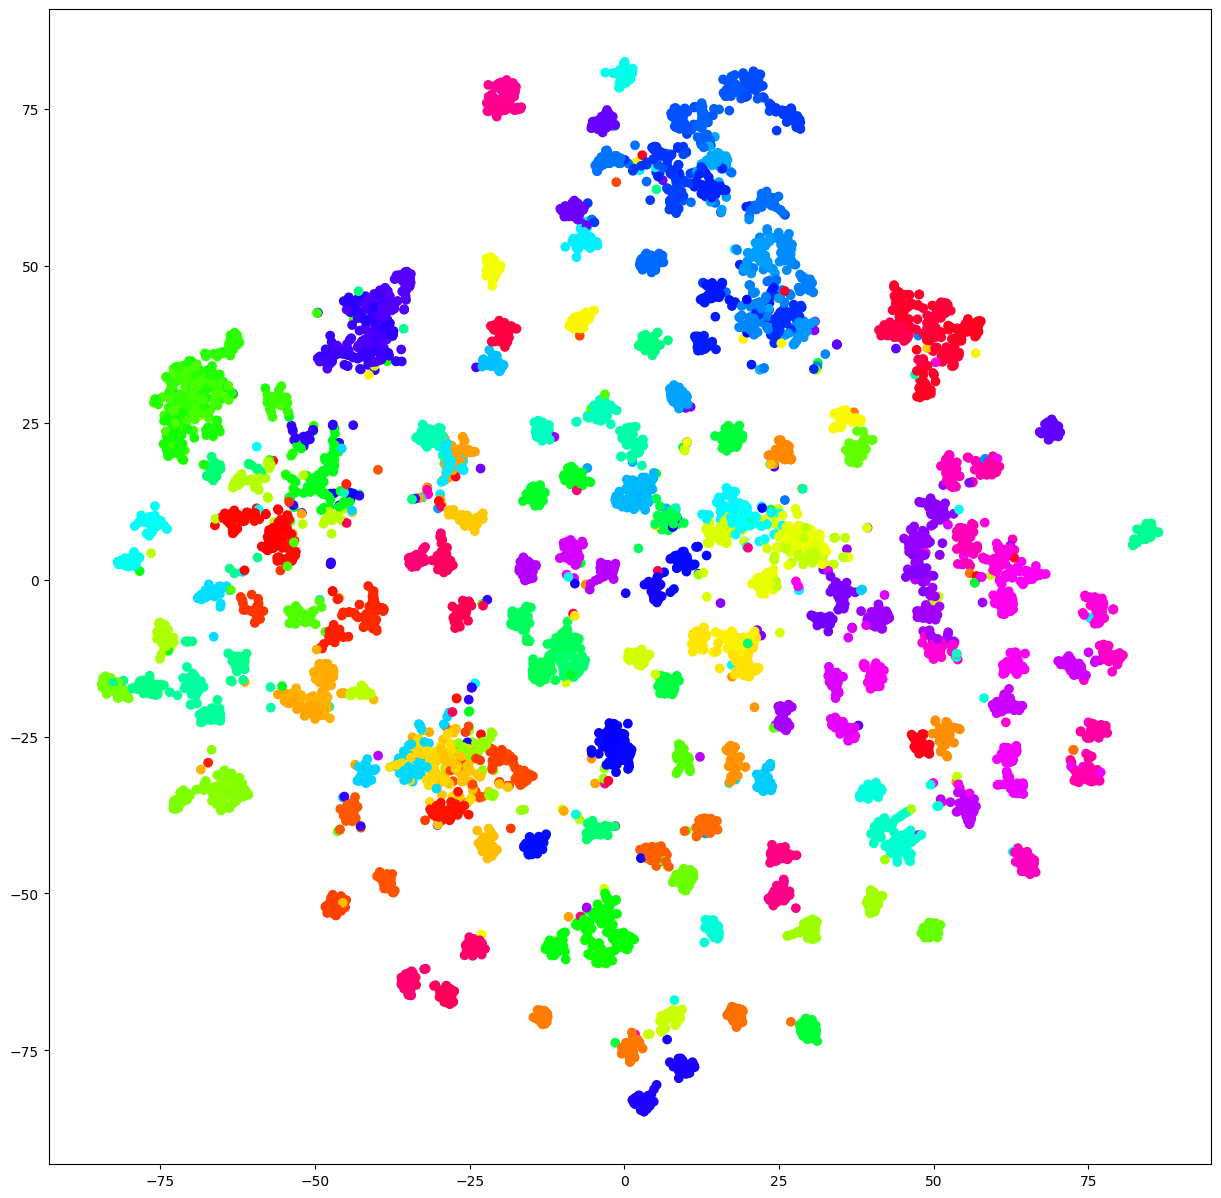

In [ ]:
output_tsne_data = get_tsne(outputs)
plot_representations(output_tsne_data, labels, classes)

# To do as home work

1. Plot the t-SNE without loading the trained weights i.e. directly use the ImageNet weights and compare the results.